In [1]:
suppressPackageStartupMessages({
    library(HGNChelper)
    library(stringr)
    library(tidyverse)
    library(limma)
    library(GSVA)
    library(edgeR)
    library(ggsignif)
    library(survival)
    library(ROCR)
})

Warning message:
“package ‘limma’ was built under R version 4.1.3”
Warning message:
“package ‘edgeR’ was built under R version 4.1.3”


In [2]:
normals <- c(
    "BRCA" = "BREAST",
    "COAD" = "COLON",
    "READ" = "COLON",
    "ESCA" = "ESOPHAGUS",
    "LIHC" = "LIVER",
    "LUAD" = "LUNG",
    "PAAD" = "PANCREAS",
    "PRAD" = "PROSTATE",
    "STAD" = "STOMACH"
)
presigs <- c(
    'STAD' = 'M5',
    'BRCA' = 'M4',
    'CRC' = 'M9',
    'ESCA' = 'M1',
    'LIHC' = 'M2',
    'LUAD' = 'M1',
    'PAAD' = 'M4',
    'PRAD' = 'M6'
)
cancer_types <- names(normals)

In [3]:
cancer <- "BRCA"
dt.tcga <- get(load(paste0(cancer, ".RData")))
dt.gtex <- get(load(paste0(normals[cancer], ".RData")))

cancer.alias <- "BRCA"
sigs <- read.table(paste0("/data/egc21/data_db/6.signature.v1.6.median/", cancer.alias, ".txt"), header = T)[[presigs[[cancer.alias]]]]

In [4]:
metadata <- dt.tcga@colData
keywords <- c("type", "patho", "histo", "molecu", "sub")
nn <- names(dt.tcga@colData)[grepl(paste(keywords, collapse = "|"), names(dt.tcga@colData))]
tt <- lapply(nn, function(x) {
    tmp <- table(dt.tcga@colData[[x]])
    if(length(tmp) < 30 & length(tmp) > 1) {tmp} else{NA}
})
names(tt) <- nn
tt <- tt[!is.na(tt)]
tt

$tcga.cgc_sample_sample_type

         Metastatic       Primary Tumor Solid Tissue Normal 
                  7                1127                 112 

$tcga.gdc_cases.samples.sample_type_id

   1    6   11 
1127    7  112 

$tcga.gdc_cases.samples.sample_type

         Metastatic Primary solid Tumor       Primary Tumor Solid Tissue Normal 
                  7                   8                1127                 114 

$tcga.cgc_sample_sample_type_code

   1    6   11 
1135    7  114 

$tcga.cgc_case_pathologic_n

       N0   N0 (i-)   N0 (i+) N0 (mol+)        N1       N1a       N1b       N1c 
      383       168        28         1       140       187        46         4 
     N1mi        N2       N2a        N3       N3a       N3b       N3c        NX 
       43        63        69        27        50         3         1        23 

$tcga.cgc_case_histological_diagnosis

      Infiltrating Carcinoma NOS    Infiltrating Ductal Carcinoma 
                               1              

In [40]:
tcgagtexCnt <- cbind(dt.tcga[, dt.tcga$tcga.gdc_cases.samples.sample_type %in% c("Primary Tumor", "Solid Tissue Normal")]@assays@data$raw_counts[,],
     dt.gtex@assays@data$raw_counts[,])
tgDGE = DGEList(tcgagtexCnt)
sampleTCGA <- intersect(rownames(tgDGE$samples), colnames(dt.tcga))
tgDGE$samples$group <- "Normal"
TCGASampleType <- c("Primary Tumor" = "Tumor", "Solid Tissue Normal" = "Adjecent")
tgDGE$samples[sampleTCGA,]$group <- TCGASampleType[dt.tcga@colData[sampleTCGA, 'tcga.cgc_sample_sample_type']]

In [55]:
tcgagtexCnt <- cbind(dt.tcga[, dt.tcga$tcga.gdc_cases.samples.sample_type %in% c("Primary Tumor", "Solid Tissue Normal")]@assays@data$raw_counts[,],
     dt.gtex@assays@data$raw_counts[,])
tgDGE = DGEList(tcgagtexCnt)
sampleTCGA <- intersect(rownames(tgDGE$samples), colnames(dt.tcga))
tgDGE$samples$group <- "Normal"
TCGASampleType <- c("Primary Tumor" = "Tumor", "Solid Tissue Normal" = "Adjecent")
tgDGE$samples[sampleTCGA,]$group <- TCGASampleType[dt.tcga@colData[sampleTCGA, 'tcga.gdc_cases.samples.sample_type']]

duplicated.gene <- table(dt.tcga@rowRanges$gene_name) %>% .[.>1] %>% names
RKPM <- tgDGE$counts / dt.tcga@rowRanges[rownames(tgDGE$counts),]$bp_length
TPM <- t(t(RKPM)*1e6/colSums(RKPM))
head(TPM[,1:6])

TPM.gene_name <- data.frame(TPM)
colnames(TPM.gene_name) <- colnames(TPM)
TPM.gene_name <- TPM.gene_name %>% rownames_to_column("gene_id") %>% inner_join(data.frame(dt.gtex@rowRanges) %>% select(gene_id, gene_name))
TPM.gene_name.1 <- TPM.gene_name %>% filter(!gene_name %in% duplicated.gene)
TPM.gene_name.2 <- TPM.gene_name %>% filter(gene_name %in% duplicated.gene) %>%
    group_by(gene_name) %>%
    summarise(across(where(is.numeric), sum))
TPM.gene_name.final <- bind_rows(TPM.gene_name.1, TPM.gene_name.2)
rownames(TPM.gene_name.final) <- TPM.gene_name.final$gene_name
TPM.gene_name.final <- TPM.gene_name.final %>% select(-c("gene_name", "gene_id"))
head(TPM.gene_name.final[1:6])

ssgsea.results <- gsva(as.matrix(TPM.gene_name.final), data.frame(sigs), method = "ssgsea", ssgsea.norm = T)

ssgsea.data <- data.frame(t(ssgsea.results))
ssgsea.data$group <- factor(tgDGE$samples[rownames(ssgsea.data),]$group, levels = c("Normal", "Adjecent", "Tumor"))
table(ssgsea.data$group)
ssgsea.data <- ssgsea.data %>%
#     filter(group != "Adjecent") %>%
    mutate(score = as.numeric(scale(sigs)))
head(ssgsea.data)

,0b1cf6de-f98f-4020-baa7-c4fc518e5f00,20c90e97-e900-488e-af6a-6648d9a8bb01,0a2fa7c7-0810-4d65-b16c-4a1792714802,cb2498a3-ade5-44a1-9df8-c611cde2ae03,30f32969-5278-4066-bb82-7400cdce8807,f9e194a1-e5c1-4a1a-840b-4e0246640d09
ENSG00000278704.1,0,0,0,0,0,0
ENSG00000277400.1,0,0,0,0,0,0
ENSG00000274847.1,0,0,0,0,0,0
ENSG00000277428.1,0,0,0,0,0,0
ENSG00000276256.1,0,0,0,0,0,0
ENSG00000278198.1,0,0,0,0,0,0


Joining, by = "gene_id"


,0b1cf6de-f98f-4020-baa7-c4fc518e5f00,20c90e97-e900-488e-af6a-6648d9a8bb01,0a2fa7c7-0810-4d65-b16c-4a1792714802,cb2498a3-ade5-44a1-9df8-c611cde2ae03,30f32969-5278-4066-bb82-7400cdce8807,f9e194a1-e5c1-4a1a-840b-4e0246640d09
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BX004987.1,0,0,0,0,0,0
AC145212.2,0,0,0,0,0,0
AC145212.1,0,0,0,0,0,0
AC011043.1,0,0,0,0,0,0
AC011043.2,0,0,0,0,0,0
AC011841.1,0,0,0,0,0,0


Warning message in .filterFeatures(expr, method):
“562 genes with constant expression values throuhgout the samples.”


Estimating ssGSEA scores for 1 gene sets.
  |======================================================================| 100%




  Normal Adjecent    Tumor 
     482      114     1127 

,sigs,group,score
,<dbl>,<fct>,<dbl>
0b1cf6de-f98f-4020-baa7-c4fc518e5f00,2.367664,Tumor,-0.63332467
20c90e97-e900-488e-af6a-6648d9a8bb01,2.556849,Tumor,0.77618991
0a2fa7c7-0810-4d65-b16c-4a1792714802,2.533057,Tumor,0.59892548
cb2498a3-ade5-44a1-9df8-c611cde2ae03,2.156565,Tumor,-2.20610939
30f32969-5278-4066-bb82-7400cdce8807,2.644858,Tumor,1.43189519
f9e194a1-e5c1-4a1a-840b-4e0246640d09,2.462158,Tumor,0.07069747


In [6]:
ssgsea.data.tumor <- ssgsea.data %>% filter(group == "Tumor") %>%
    rownames_to_column("external_id") %>%
    inner_join(dt.tcga@colData %>% data.frame, by = "external_id")
keywords <- c("tcga.cgc_case_histological_diagnosis","tcga.cgc_case_pathologic_stage","tcga.xml_histological_type","tcga.xml_histological_type_other","tcga.xml_stage_event_pathologic_stage","tcga.xml_axillary_lymph_node_stage_method_type","tcga.xml_her2_immunohistochemistry_level_result","tcga.xml_lab_proc_her2_neu_immunohistochemistry_receptor_status")

Warning message:
“Removed 804 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 804 rows containing non-finite values (stat_signif).”
Warning message:
“Removed 542 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 542 rows containing non-finite values (stat_signif).”
Warning message:
“Removed 542 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 542 rows containing non-finite values (stat_signif).”
Warning message:
“Removed 548 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 548 rows containing non-finite values (stat_signif).”
Warning message:
“Removed 18 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 18 rows containing non-finite values (stat_signif).”
Warning message:
“Removed 545 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 545 rows containing non-finite values (stat_signif).”
Warning message:
“Removed 429 rows c

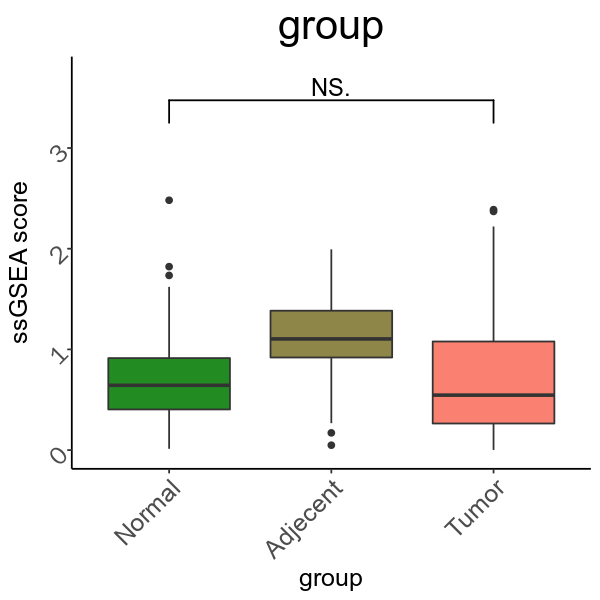

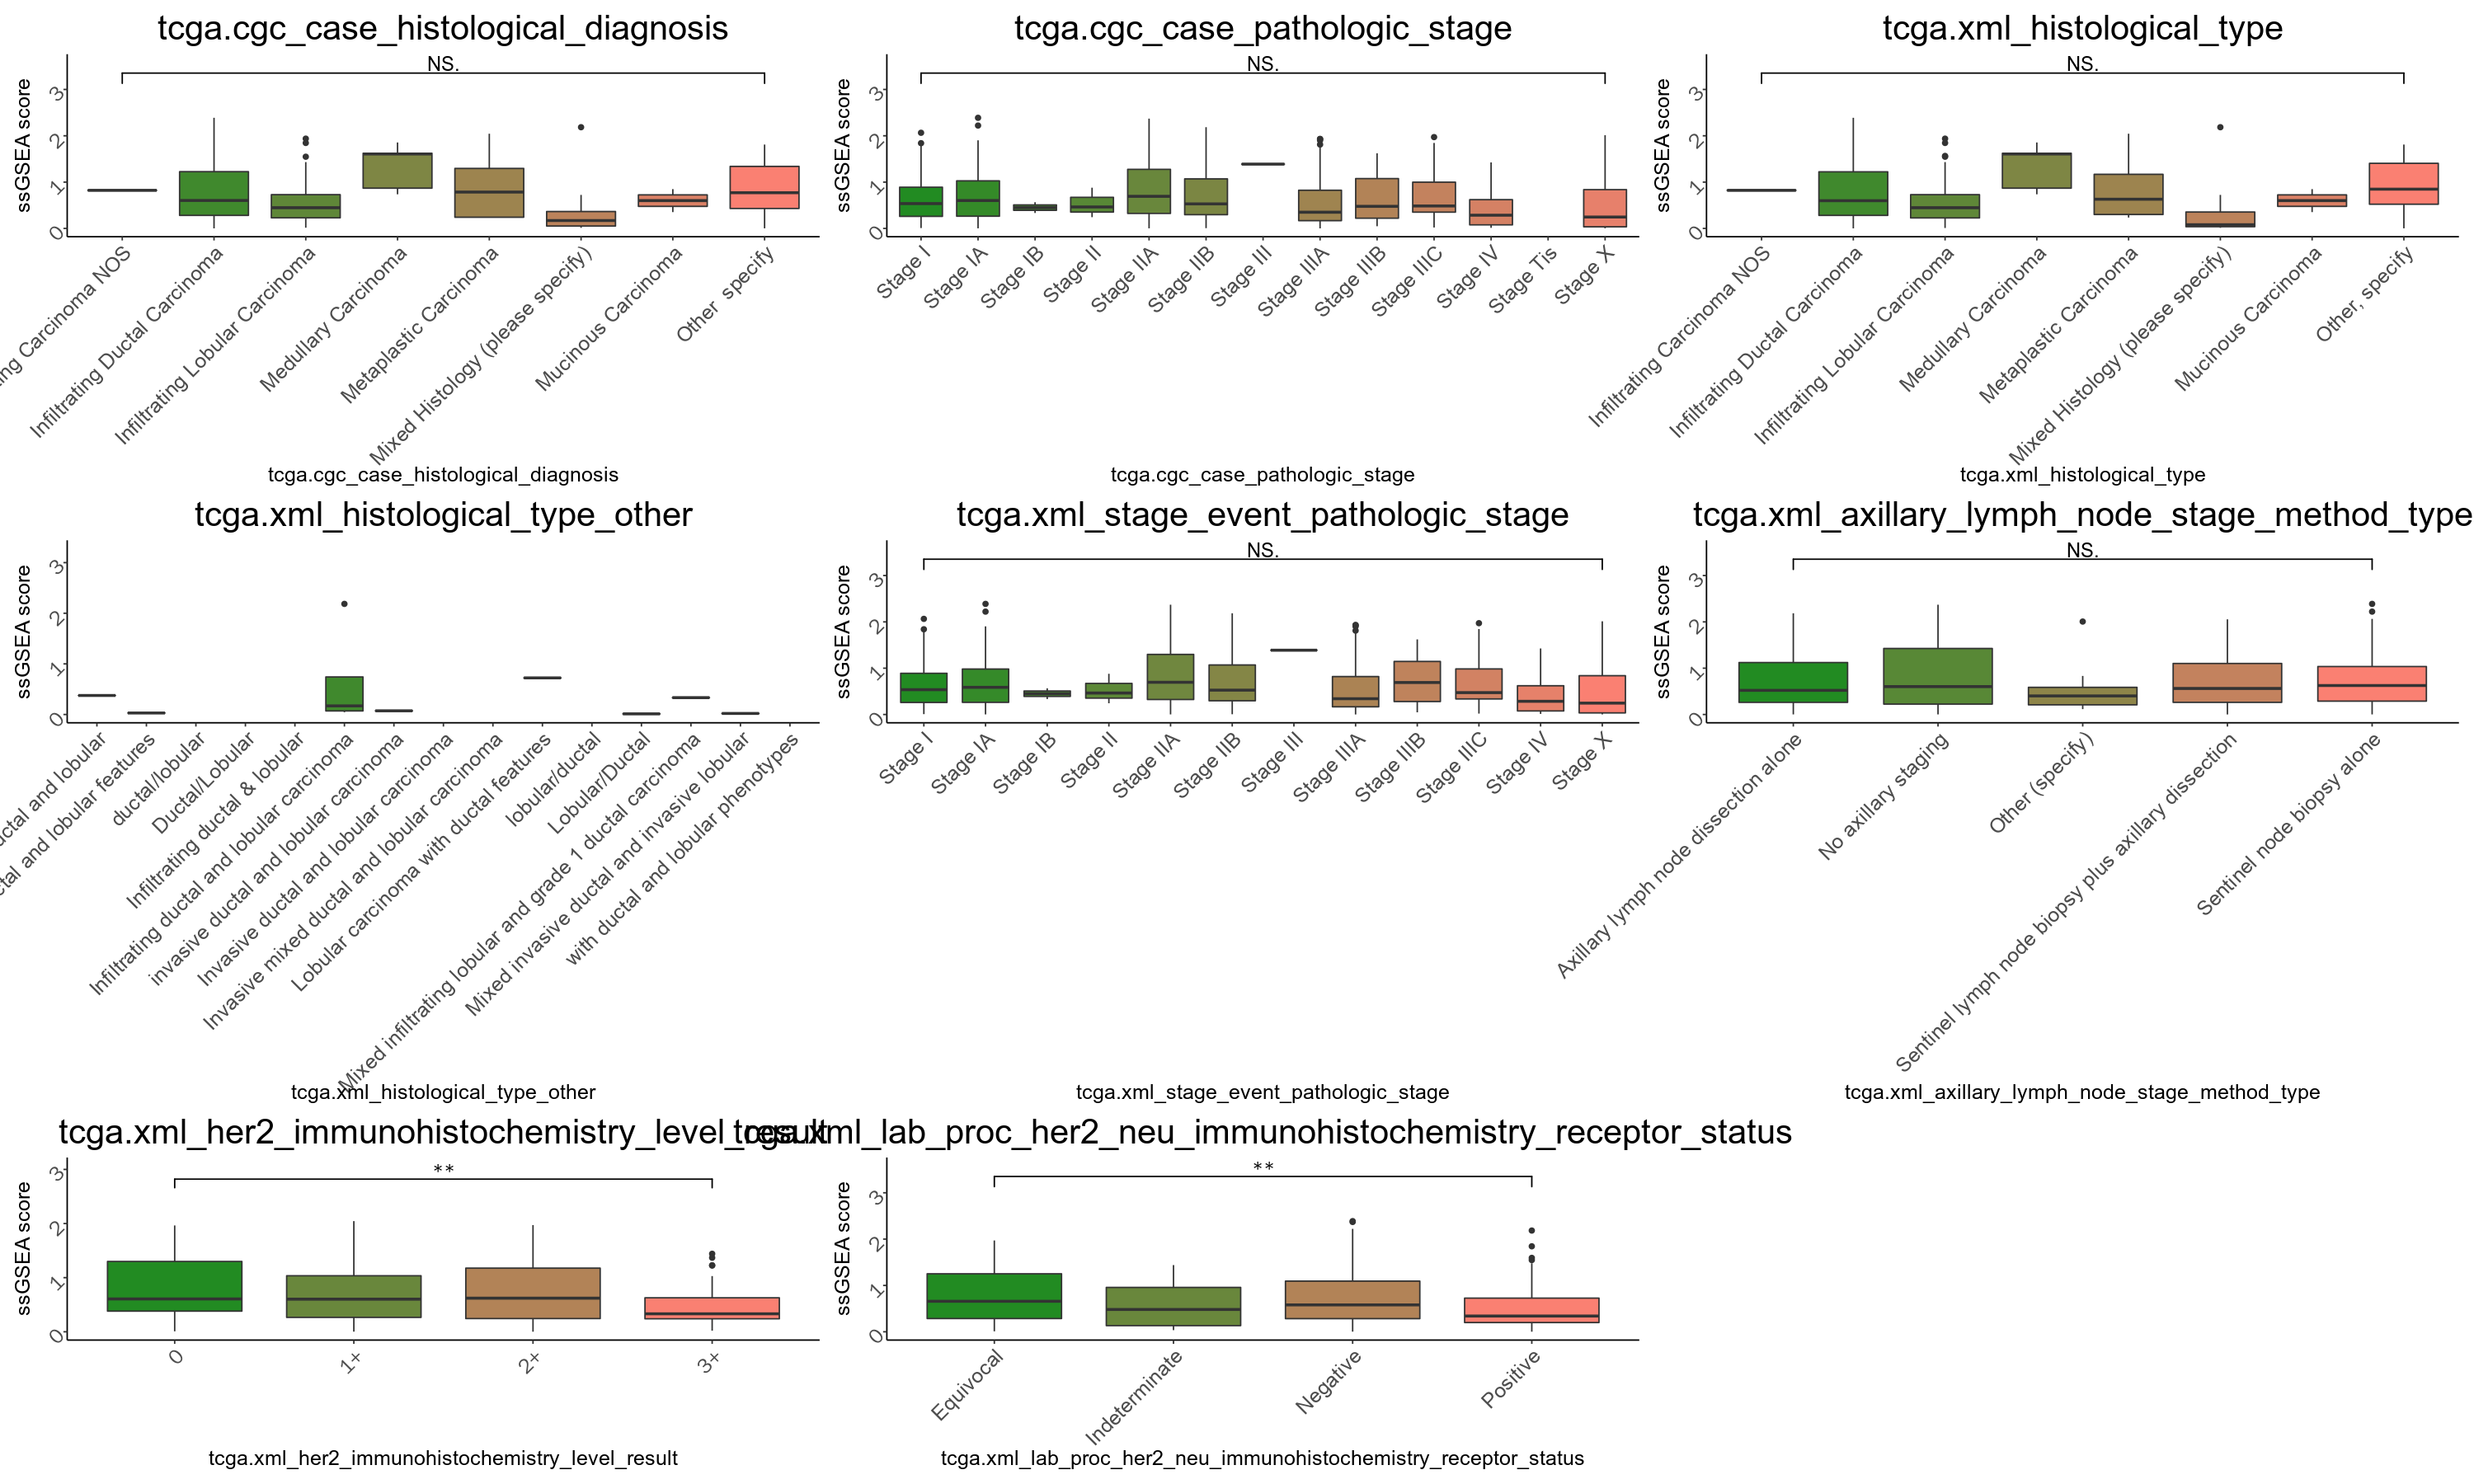

In [7]:
my_boxplot <- function(dt, value, gg){
    dt <- dt[!is.na(dt[[gg]]),]
    groups <- sort(unique(dt[[gg]]))
    mm = max(dt[[value]])
    nn = length(groups)
    ggplot(dt, aes(x = .data[[gg]], y = .data[[value]])) +
        geom_boxplot(aes(fill = .data[[gg]])) +
        scale_fill_manual(values = colorRampPalette(c("#228B22", "#FA8072"))(nn)) +
        labs(y = "ssGSEA score", title = gg) +
        geom_signif(
            comparisons = list(c(groups[length(groups)], groups[1])),
            test = wilcox.test,
            test.args = list(
                alternative = "two.sided",
                var.equal = FALSE,
                paired=FALSE),
            map_signif_level = T,
            textsize = 5,
            y_position = mm*1.25) +
        theme(
            panel.background = element_blank(),
            axis.line = element_line()) +
        theme(plot.title = element_text(hjust = 0.5, size = 25)) +
        theme(axis.text = element_text(size = 15, angle = 45, hjust = 1), axis.title = element_text(size = 15)) +
        scale_y_continuous(limits = c(0, mm*1.5)) +
        theme(legend.position = 'none') +
        NULL
}
options(repr.plot.height = 5, repr.plot.width = 5)
my_boxplot(ssgsea.data, "score", "group")
options(repr.plot.height = 15, repr.plot.width = 25)
patchwork::wrap_plots(lapply(keywords, function(x) {my_boxplot(ssgsea.data.tumor, "score", x)}))

[1] 0.9069800 1.0833697 1.2807741 0.6992014 1.0054094 0.9145138

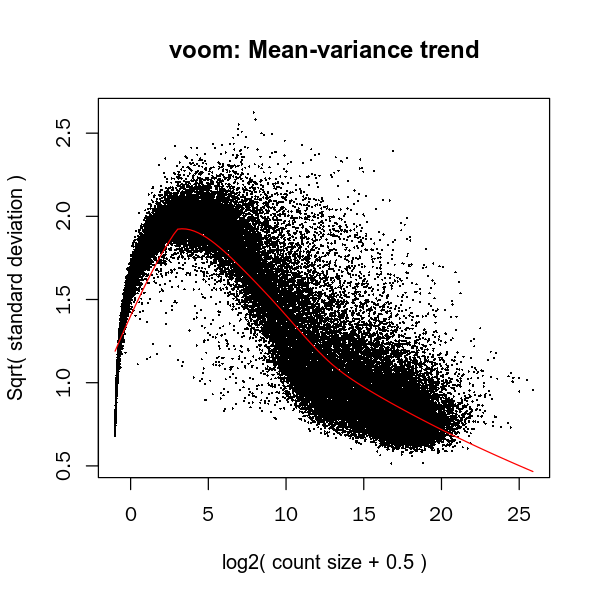

       TCGAvsGTEX
Down        32082
NotSig      10017
Up          21757

       TCGAvsGTEX
Down        14605
NotSig      36799
Up          12452

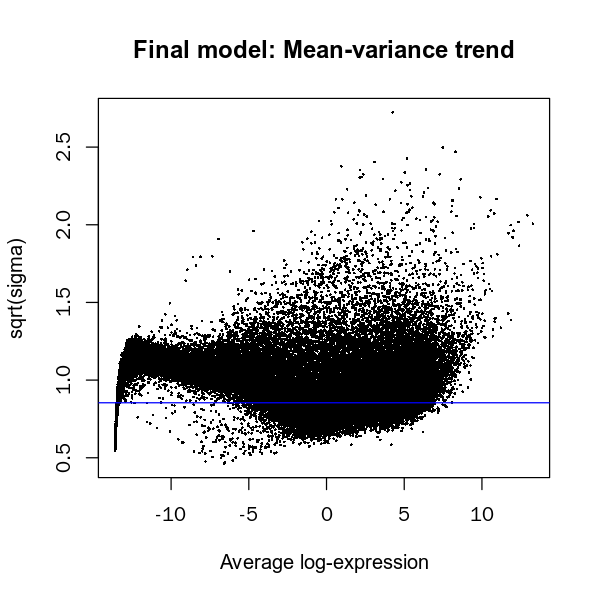

In [56]:

options(repr.plot.height = 5, repr.plot.width = 5)
# Step-17
x = calcNormFactors(tgDGE, method = "upperquartile")
head(x$samples$norm.factors)
group <- x$samples$group


# Step-18
design = model.matrix(~0 + group)


# Step-19
colnames(design) = gsub("group", "", colnames(design))
contr.matrix = makeContrasts(TCGAvsGTEX = Tumor - Normal,
    levels = colnames(design))


# Step-20
v = voom(x, design, plot = T)


# Step-21
vfit = lmFit(v, design)
vfit = contrasts.fit(vfit, contrasts = contr.matrix)


# Step-22
efit = eBayes(vfit)
plotSA(efit, main = "Final model: Mean-variance trend")

# Step-23
summary(decideTests(efit))
tfit = treat(vfit, lfc = 0.58)
summary(decideTests(tfit))


# Step-24
DEGsTreat = topTreat(tfit, n = Inf)

,logFC,AveExpr,t,P.Value,adj.P.Val,gene_name
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000221978.11,-2.258925,6.6802343,-57.30042,0,0,CCNL2
ENSG00000238249.2,4.586416,-0.3672343,57.12008,0,0,HMGN2P17
ENSG00000011021.21,-1.811379,4.3113989,-55.59061,0,0,CLCN6
ENSG00000242349.5,-2.364709,0.5340157,-52.73801,0,0,NPPA-AS1
ENSG00000175206.10,-4.018016,-1.8100320,-50.39418,0,0,NPPA
ENSG00000276830.1,-4.033290,-5.2293753,-58.41277,0,0,MIR6730


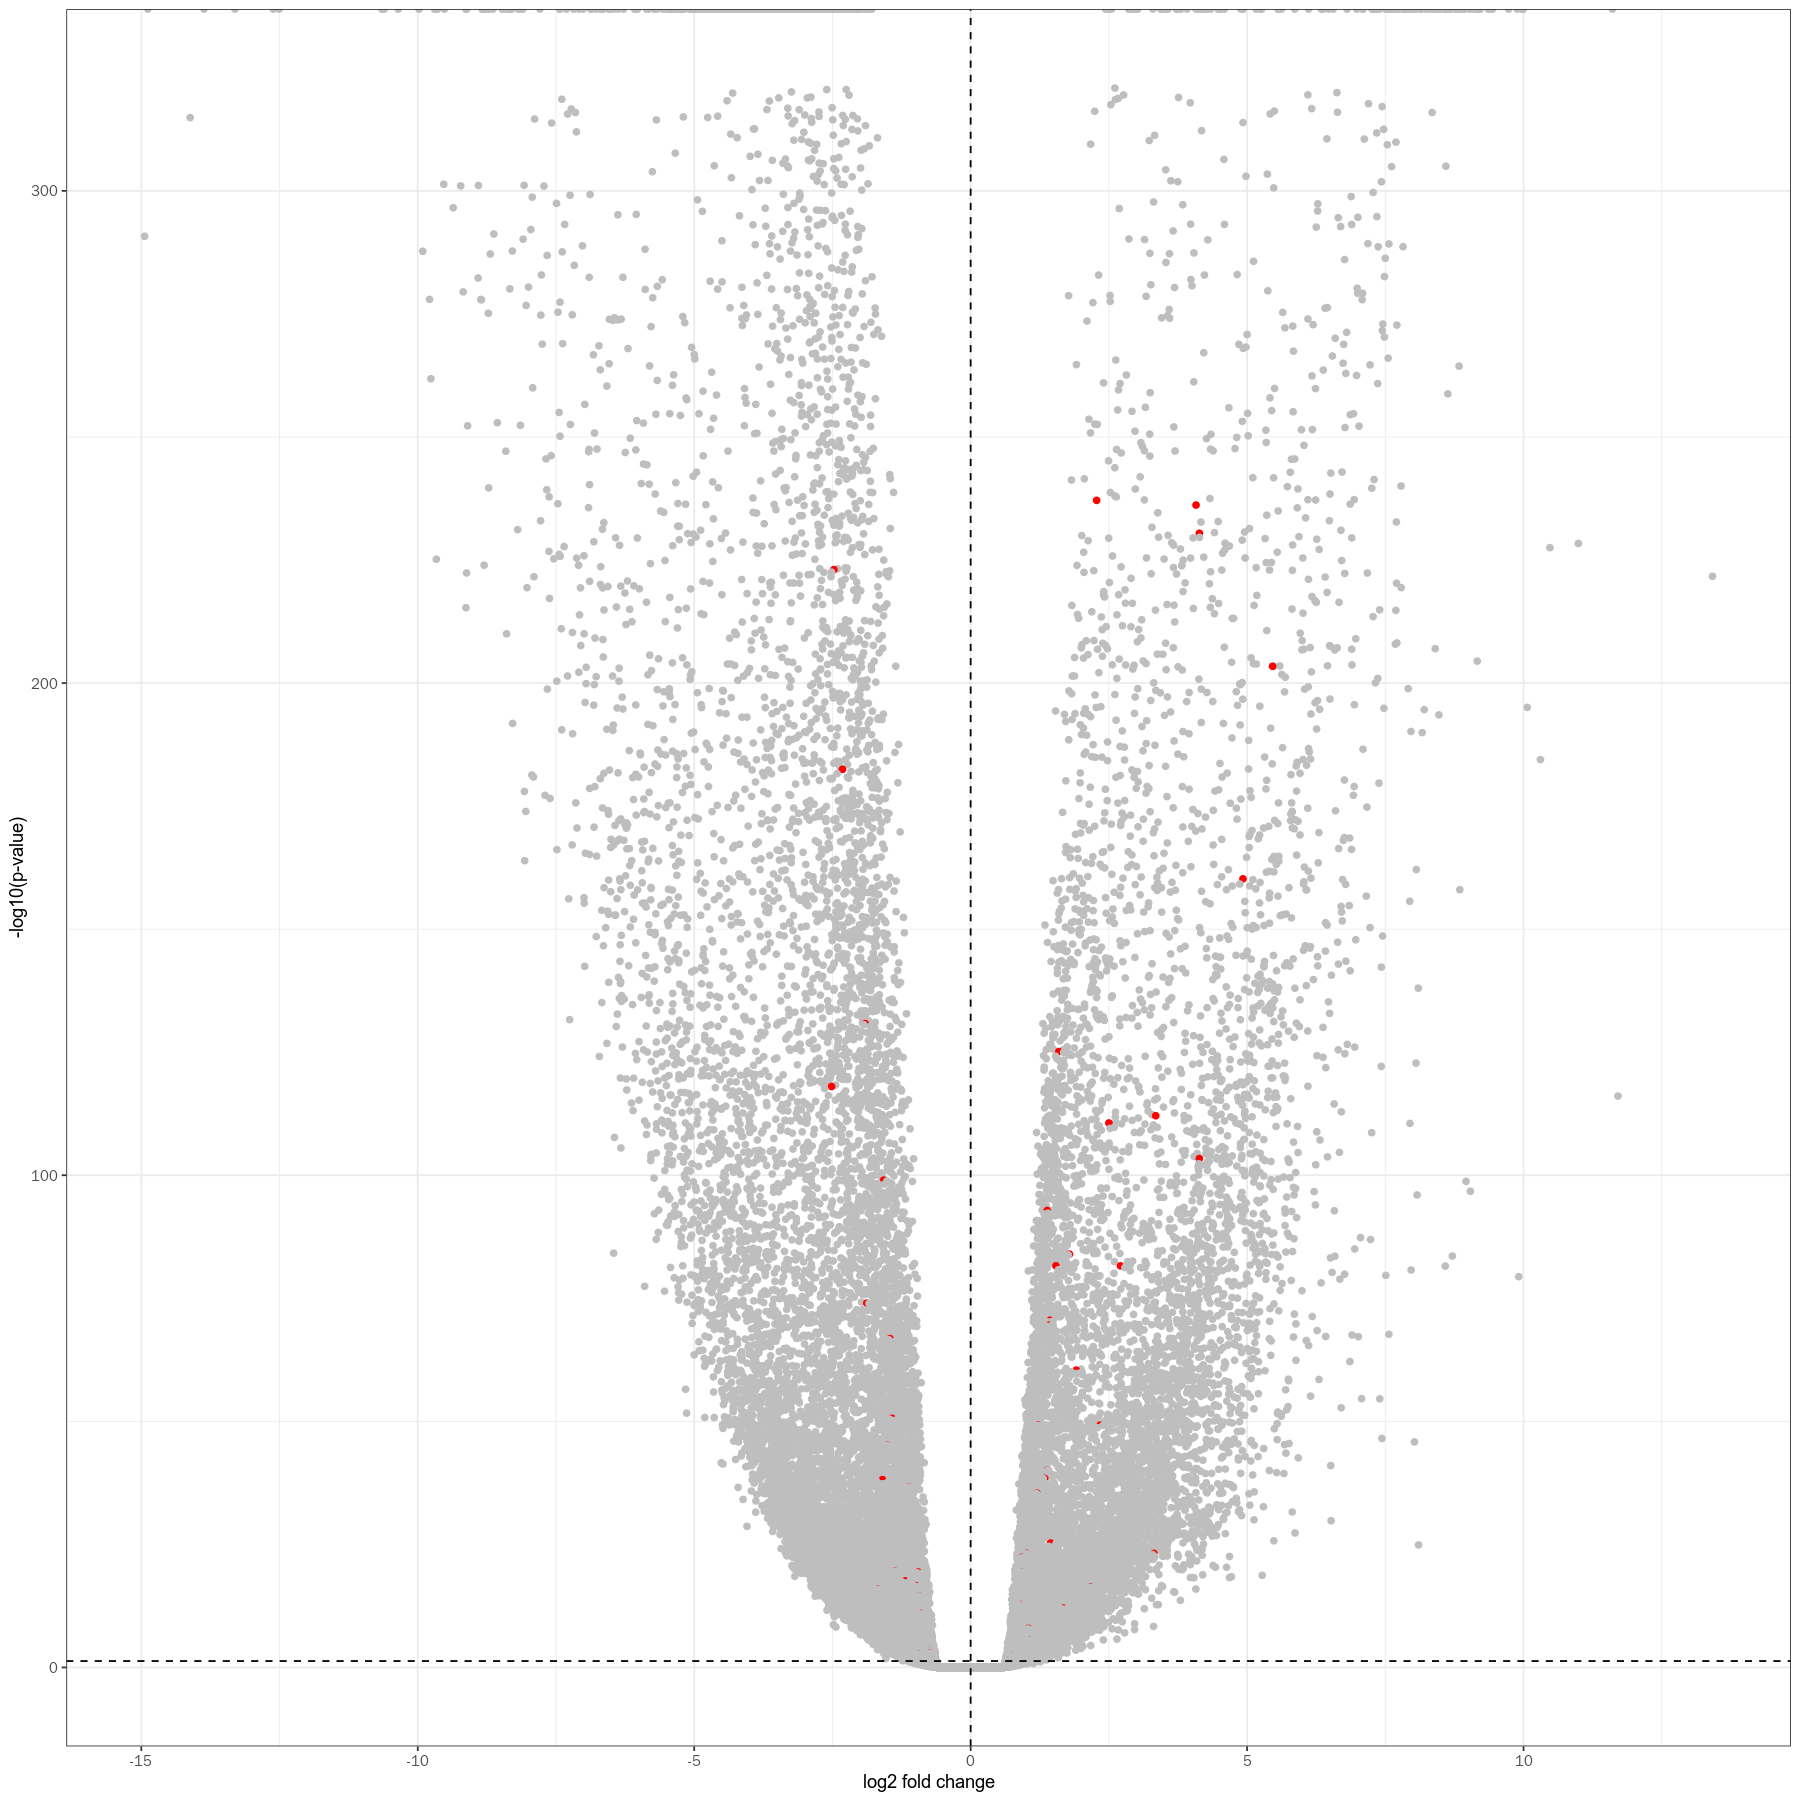

In [58]:
DEGsTreat$gene_name <- dt.tcga@rowRanges[rownames(DEGsTreat), ]$gene_name
# DEGsTreat %>%
#     filter(abs(logFC) > 1.5, adj.P.Val < 0.05) %>%
#     filter(gene_name %in% sigs) %>%
#     filter(!duplicated(gene_name)) %>%
#     identity
head(DEGsTreat)

options(repr.plot.height = 15, repr.plot.width = 15)
DEGsTreat %>% mutate(ingroup = gene_name %in% sigs) %>%
ggplot(aes(x = logFC, y = -log10(adj.P.Val))) +
    geom_point(aes(color = ingroup)) +
    geom_hline(yintercept = -log10(0.05), linetype = "dashed") +
    geom_vline(xintercept = 0, linetype = "dashed") +
    scale_color_manual(values = c("grey", "red")) +
    theme_bw() +
    theme(legend.position = "none") +
    labs(x = "log2 fold change", y = "-log10(p-value)")

In [59]:
survival_data <- ssgsea.data.tumor %>% transmute(
    time = ifelse(
        tcga.cgc_case_vital_status == "Dead",
        tcga.cgc_case_days_to_death,
        tcga.cgc_case_days_to_last_follow_up) / 30,
    deceased = tcga.cgc_case_vital_status == "Dead",
    sample_id = external_id,
    enrich_score = sigs,
    enrich_score_z = score
) %>%
    na.omit %>%
    mutate(score_group = 1*(enrich_score >= median(enrich_score)))

survival_data$expr <- colMeans(TPM.gene_name.final[intersect(rownames(TPM.gene_name.final), sigs), survival_data$sample_id])

survival_data$expr_group <- 1*(survival_data$expr >= median(survival_data$expr))

Call:
coxph(formula = m ~ score_group, data = survival_data)

  n= 1117, number of events= 104 

               coef exp(coef) se(coef)     z Pr(>|z|)
score_group -0.1502    0.8606   0.1975 -0.76    0.447

            exp(coef) exp(-coef) lower .95 upper .95
score_group    0.8606      1.162    0.5843     1.267

Concordance= 0.521  (se = 0.031 )
Likelihood ratio test= 0.58  on 1 df,   p=0.4
Wald test            = 0.58  on 1 df,   p=0.4
Score (logrank) test = 0.58  on 1 df,   p=0.4


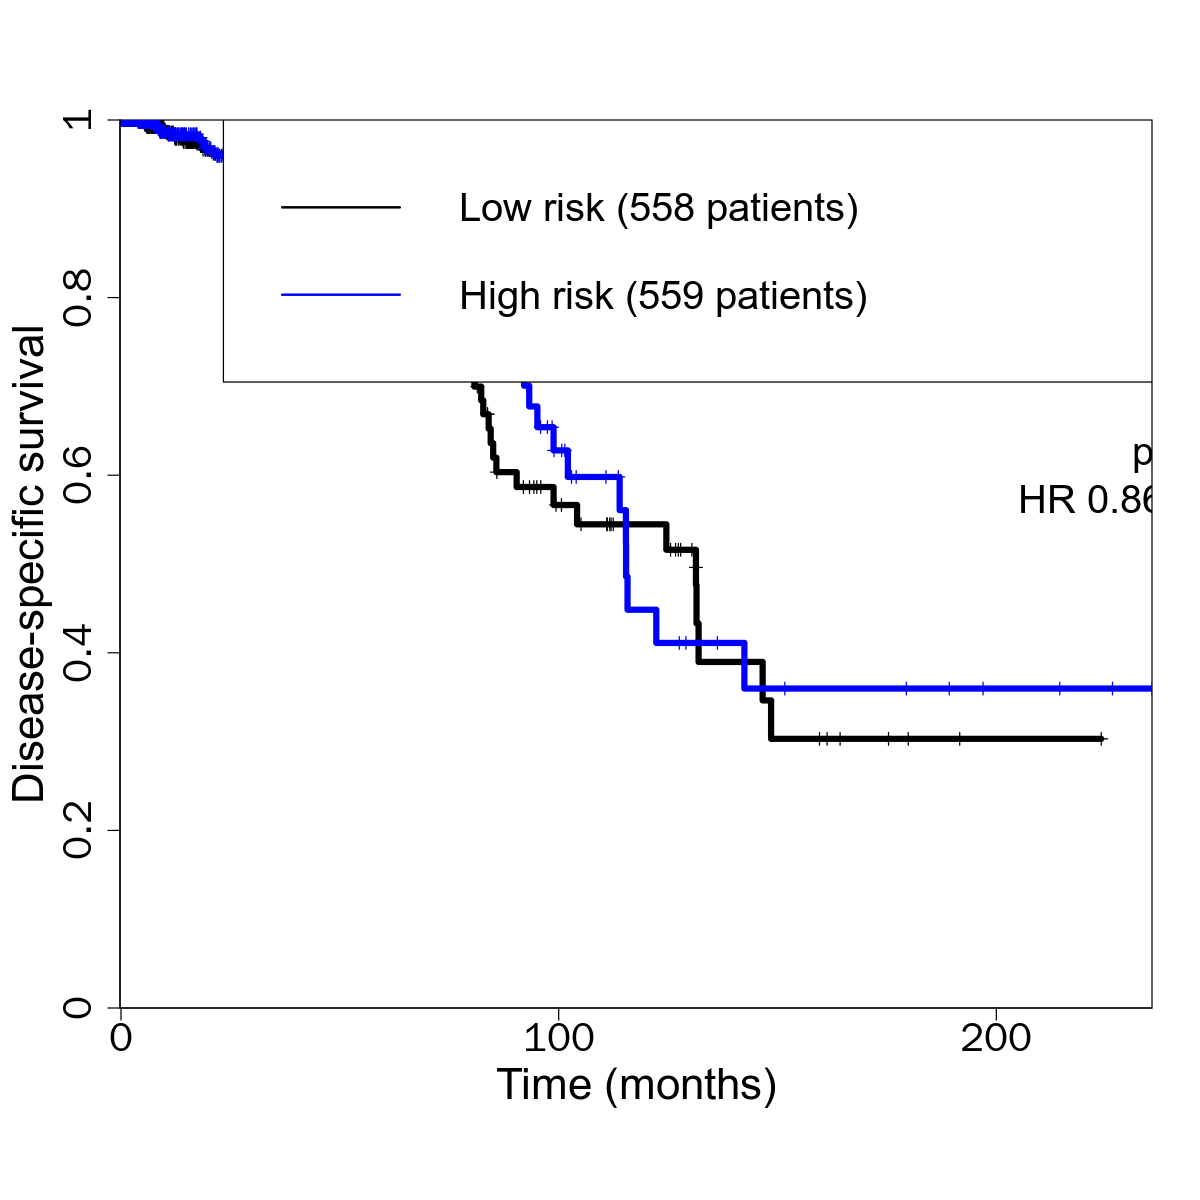

In [60]:

attach(survival_data)
m <- Surv(time, deceased)
summary(coxph(m ~ score_group, data = survival_data))

logt <- survdiff(m~score_group,data = survival_data)
p.val <- 1 - pchisq(logt$chisq, length(logt$n) - 1)
p.val <- format(p.val,digits=3)
p.val_os <- p.val
        
coxmodel <- coxph(m~score_group,data = survival_data)
fit <- summary(coxmodel)
HR <- fit$conf.int[1];
HR_os <- as.numeric(format(HR,digits=3))
low95_os <- fit$conf.int[3]; low95_os<- format(low95_os,digits=3)
up95_os <- fit$conf.int[4]; up95_os<- format(up95_os,digits=3)

kme <- survfit(formula = m ~ score_group, data = survival_data)

options(repr.plot.width = 10, repr.plot.height = 10)
par(mar = c(8,5,5,2))
plot(kme,lty = c('solid','solid'),col=c('black','blue'),lwd = c(5,5),cex.axis = 2,cex.lab = 3.5,cex.main=3,
     xaxs='i',yaxs="i",xaxt = "n",yaxt="n",mark.time = T)

axis(side = 1,
     at = c(0,100,200,300,400),
     labels = c(0,100,200,300, 400),
                   tick = 0.1,
     cex.axis=2)

axis(side = 2,
     at = c(0,.2,.4,.6,.8,1),
     labels = c(0,0.2,0.4,0.6,0.8,1),
     tick = 0.1,
     cex.axis=2)
title(ylab="Disease-specific survival", mgp=c(3,1,0), cex.lab=2.2)
title(xlab="Time (months)", mgp=c(3,1,0), cex.lab=2.2)
legend('topright',c(paste('Low risk (',length(which(score_group==0))," patients",')',sep = ""),paste('High risk (',length(which(score_group==1))," patients",')',sep = "")),lty = c('solid','solid'),col=c('black','blue'),cex = 2,lwd = c(2,2))
text(250,0.6,paste("p = ",p.val_os, "\nHR ",HR_os," (",low95_os,"-",up95_os,")",sep = ""),cex = 2)
detach(survival_data)

Call:
coxph(formula = m ~ expr_group, data = survival_data)

  n= 1117, number of events= 104 

             coef exp(coef) se(coef)     z Pr(>|z|)    
expr_group 0.7639    2.1466   0.2065 3.699 0.000216 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

           exp(coef) exp(-coef) lower .95 upper .95
expr_group     2.147     0.4658     1.432     3.217

Concordance= 0.614  (se = 0.028 )
Likelihood ratio test= 14.47  on 1 df,   p=1e-04
Wald test            = 13.69  on 1 df,   p=2e-04
Score (logrank) test = 14.36  on 1 df,   p=2e-04


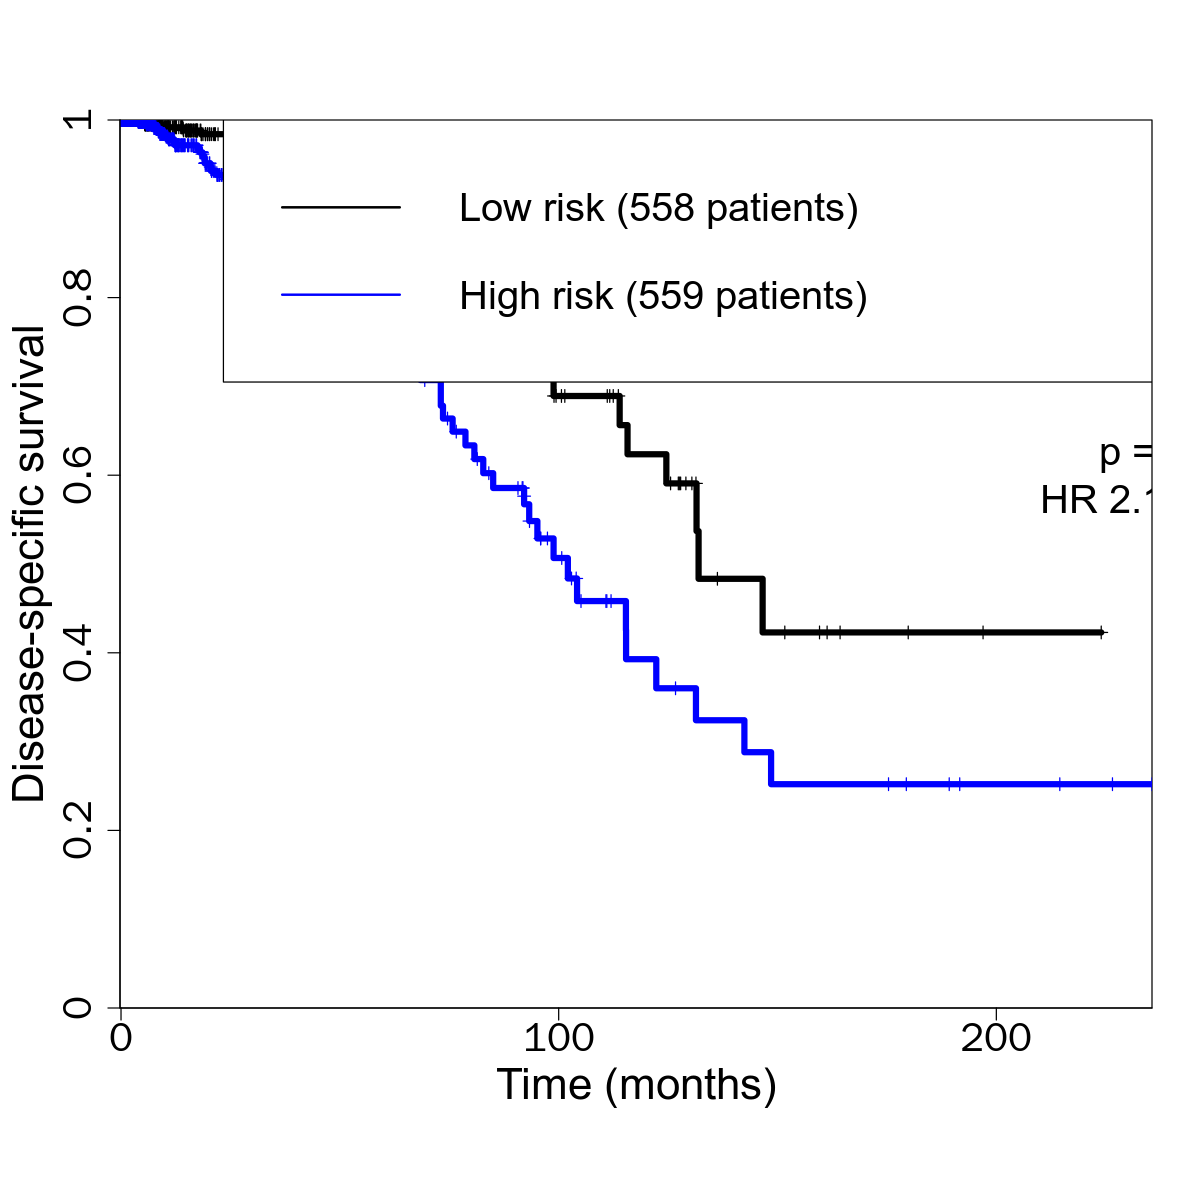

In [61]:

attach(survival_data)
m <- Surv(time, deceased)
summary(coxph(m ~ expr_group, data = survival_data))

logt <- survdiff(m~expr_group,data = survival_data)
p.val <- 1 - pchisq(logt$chisq, length(logt$n) - 1)
p.val <- format(p.val,digits=3)
p.val_os <- p.val
        
coxmodel <- coxph(m~expr_group,data = survival_data)
fit <- summary(coxmodel)
HR <- fit$conf.int[1];
HR_os <- as.numeric(format(HR,digits=3))
low95_os <- fit$conf.int[3]; low95_os<- format(low95_os,digits=3)
up95_os <- fit$conf.int[4]; up95_os<- format(up95_os,digits=3)

kme <- survfit(formula = m ~ expr_group, data = survival_data)

options(repr.plot.width = 10, repr.plot.height = 10)
par(mar = c(8,5,5,2))
plot(kme,lty = c('solid','solid'),col=c('black','blue'),lwd = c(5,5),cex.axis = 2,cex.lab = 3.5,cex.main=3,
     xaxs='i',yaxs="i",xaxt = "n",yaxt="n",mark.time = T)

axis(side = 1,
     at = c(0,100,200,300,400),
     labels = c(0,100,200,300, 400),
                   tick = 0.1,
     cex.axis=2)

axis(side = 2,
     at = c(0,.2,.4,.6,.8,1),
     labels = c(0,0.2,0.4,0.6,0.8,1),
     tick = 0.1,
     cex.axis=2)
title(ylab="Disease-specific survival", mgp=c(3,1,0), cex.lab=2.2)
title(xlab="Time (months)", mgp=c(3,1,0), cex.lab=2.2)
legend('topright',c(paste('Low risk (',length(which(expr_group==0))," patients",')',sep = ""),paste('High risk (',length(which(expr_group==1))," patients",')',sep = "")),lty = c('solid','solid'),col=c('black','blue'),cex = 2,lwd = c(2,2))
text(250,0.6,paste("p = ",p.val_os, "\nHR ",HR_os," (",low95_os,"-",up95_os,")",sep = ""),cex = 2)
detach(survival_data)